In [595]:
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.distributions import Uniform
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.5)
plt.rcParams["figure.figsize"] = (16, 8)

<h2> Synthetic Data </h2>

In [596]:
f = lambda x : 2*x**2 + x**3

x_dist = Uniform(-2, 1)

x0 = x_dist.sample((1000,))
x1 = x_dist.sample((1000,))


y0 = f(x0) + torch.randn_like(x0)*0.2
y1 = f(x1) + torch.randn_like(x1)*0.2 + 0.5

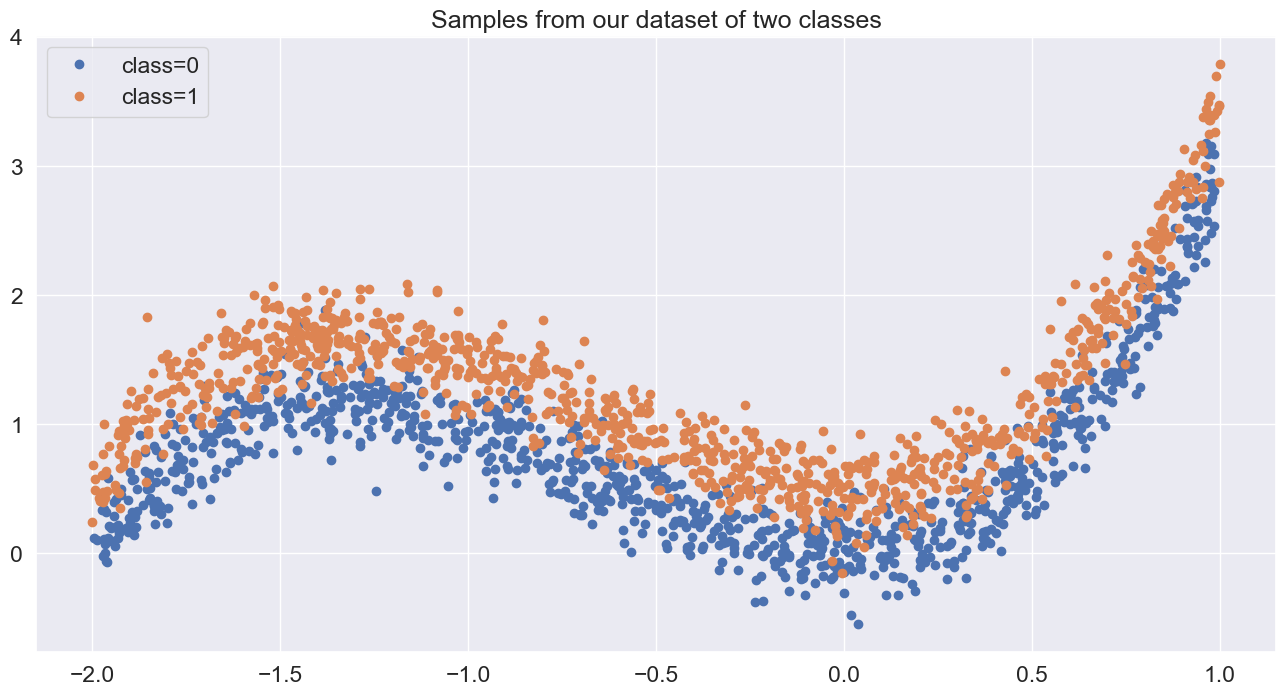

In [597]:
plt.plot(x0, y0, 'o', label="class=0")
plt.plot(x1, y1, 'o', label='class=1');
plt.title("Samples from our dataset of two classes")
plt.legend();

In [598]:
def build_dataset(x0, y0, x1, y1):
    X0 = torch.stack([x0, y0], dim=1)
    X1 = torch.stack([x1, y1], dim=1)
    X = torch.cat([X0, X1], dim=0)
    y = torch.cat([torch.zeros_like(x0), torch.ones_like(x1)], dim=0)
    # rand shuffle
    idx = torch.randperm(X.shape[0])
    X = X[idx]
    y = y[idx]
    return X, y

X, y = build_dataset(x0, y0, x1, y1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [599]:
X.shape, y.shape

(torch.Size([2000, 2]), torch.Size([2000]))

In [600]:
class LogisticRegressor(nn.Module):

    def __init__(self):
        super(LogisticRegressor, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
    
class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [601]:
def train_classifier(
        X_train,
        y_train,
        X_val,
        y_val,
        model,
        epochs=100,
        lr=0.01):

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    train_losses, val_losses = [], []
    min_val_loss, early_stop_counter, best_model = float("inf"), 0, None

    for _ in tqdm(range(epochs)):
            
        rand_idx = torch.randperm(X_train.shape[0])

        for idx in rand_idx:
            x, y = X_train[idx], y_train[:,None][idx]
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # validation
        with torch.no_grad():

            y_pred_val = model(X_val).squeeze()
            val_loss = criterion(y_pred_val, y_val)
            val_losses.append(val_loss.item())

            min_val_loss = min(min_val_loss, val_loss.item())

            if min_val_loss == val_loss.item():
                best_model = model
                early_stop_counter = 0

                probs = torch.sigmoid(y_pred_val)
                preds = (probs > 0.5).float()

                metrics = {
                    "accuracy": accuracy_score(y_val, preds),
                    "precision": precision_recall_fscore_support(y_val, preds, average="binary")[0],
                    "recall": precision_recall_fscore_support(y_val, preds, average="binary")[1],
                    "f1": precision_recall_fscore_support(y_val, preds, average="binary")[2]
                }

            else:
                early_stop_counter += 1

    return best_model, metrics, train_losses, val_losses

In [602]:
logistic = LogisticRegressor()
logistic, lr_metrics, train_losses, val_losses = train_classifier(
    X_train, y_train, X_val, y_val, logistic, epochs=20, lr=0.01
)

100%|██████████| 20/20 [00:02<00:00,  6.81it/s]


In [603]:
lr_metrics

{'accuracy': 0.485,
 'precision': 0.485,
 'recall': 1.0,
 'f1': 0.6531986531986532}

In [604]:
neural_net = NeuralNetwork()
neural_net, nn_metrics, train_losses, val_losses = train_classifier(
    X_train, y_train, X_val, y_val, neural_net, epochs=20, lr=0.01
)

100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


In [605]:
nn_metrics

{'accuracy': 0.485,
 'precision': 0.485,
 'recall': 1.0,
 'f1': 0.6531986531986532}

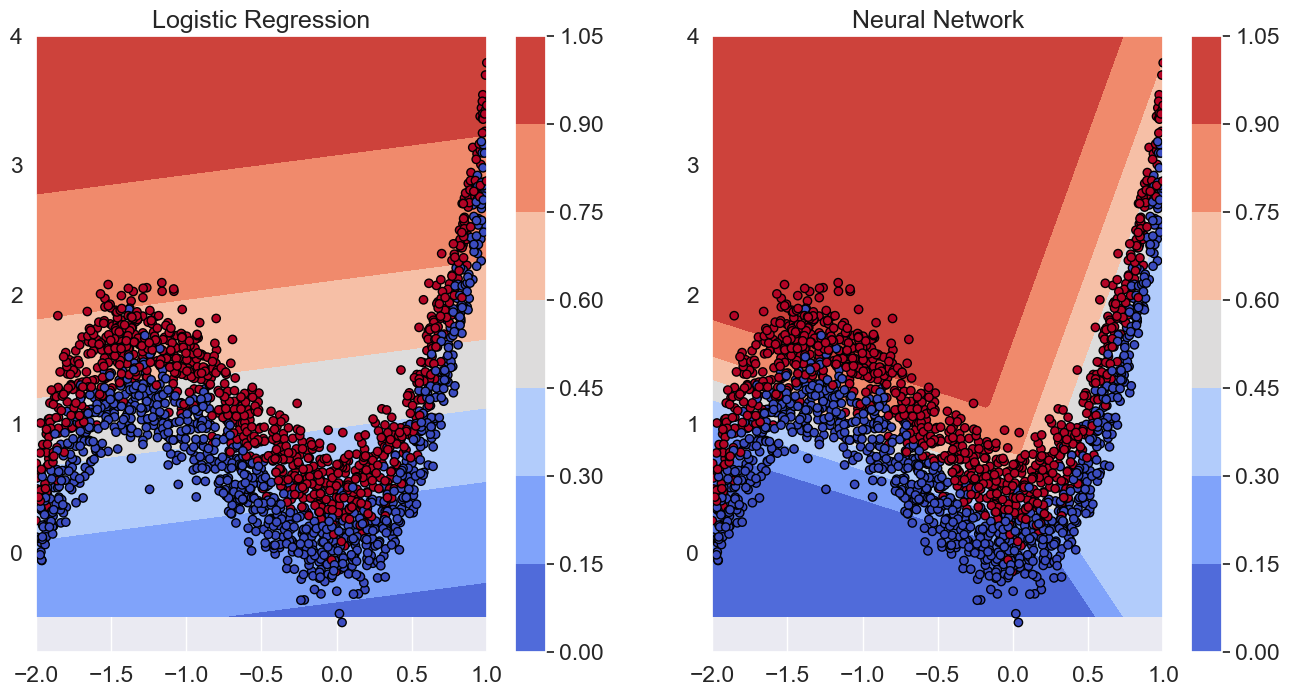

In [606]:
x_values = torch.linspace(-2, 1, steps=100)
y_values = torch.linspace(-0.5, 4.0, steps=100)
mesh_x, mesh_y = torch.meshgrid(x_values, y_values, indexing="ij")
coordinates = torch.stack((mesh_x.flatten(), mesh_y.flatten()), dim=1)

logistic_preds = logistic(coordinates).detach().numpy().reshape(100, 100)
neural_net_preds = neural_net(coordinates).detach().numpy().reshape(100, 100)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot coordinates with logistic predictions color coded
contour = ax[0].contourf(mesh_x, mesh_y, logistic_preds, cmap="coolwarm")
ax[0].scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolors="black")
ax[0].set_title("Logistic Regression")
fig.colorbar(contour, ax=ax[0], orientation="vertical")

# Plot coordinates with neural network predictions color coded
contour = ax[1].contourf(mesh_x, mesh_y, neural_net_preds, cmap="coolwarm")
ax[1].scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolors="black")
ax[1].set_title("Neural Network")
fig.colorbar(contour, ax=ax[1], orientation="vertical");


$$
\hat{y} = s(X w)
$$

$$
\hat{y} = s(f(X W) w)
$$

$$
\hat{y} = s(f_1(f_0(X W_0)W_1) w)
$$

$$
\hat{y} = s(f_2(f_1(f_0(X W_0)W_1)W_2) w)
$$

$$
f(w) = - y \log(s(Xw)) - (1 - y) \log(1 - s(Xw))
$$

$$
\nabla f(w) = X^T (s(Xw) - y)
$$